<a href="https://colab.research.google.com/github/nilaynishant/AIMLTutorial/blob/main/05_svm_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# run this only if you have not installed the requried packages
!pip install rasterio
!pip install geopandas
!pip install gitpython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 14.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [ ]:
import os
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import git

repo_url = 'https://github.com/waleedgeo/lulc_py.git'  # set the URL of the repository
repo_dir = 'https://github.com/waleedgeo/lulc_py/tree/main/materials'  # set the path to the local repository directory
if not os.path.exists('/content/https:/github.com/waleedgeo/lulc_py/tree/main/materials/'):
  git.Repo.clone_from(repo_url, repo_dir)
# variables 
# Note: labels should be always last column with name "labels"
# Note: Make sure input labels shapefile and input raster have same CRS, otherwise code will not run

# input files
raster_loc = '/content/https:/github.com/waleedgeo/lulc_py/tree/main/materials/materials/rasters/s2image.tif'
points_loc = '/content/https:/github.com/waleedgeo/lulc_py/tree/main/materials/materials/shapefiles/samples.shp'
temp_point_loc = '/content/https:/github.com/waleedgeo/lulc_py/tree/main/materials/materials/temp/temp_y_points.shp'

# land cover names (for post visualization)
lulc_name = ['Water', 'Dense Veg', 'Veg', 'Impervious']

#  reading bands from input
with rio.open(raster_loc) as img:
    bands = (img.read()).shape[0]
print('Bands of input image: ', bands)

# using ilteration to automatically create a bands list

features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
f_len = len(features)

points = gpd.read_file(points_loc)
# adding a new column 'id' with range of points
points = points.assign(id=range(len(points)))
# saving nenw point file with 'id'
points.to_file(temp_point_loc) 
# converting gdf to pd df and removing geometry
points_df = pd.DataFrame(points.drop(columns='geometry'))

# ilterating over multiband raster
sampled = pd.Series()

#inputShape= temp_point_loc
# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(raster_loc) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas serie accordingly
        sampled.loc[siteID] = value

# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(), 
                   columns=features)
df1['id'] = df1.index

data = pd.merge(df1, points_df, on ='id')
print('Sampled Data: \n',data)

x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-1]
Y = y.values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

Bands of input image:  4
Bands names:  ['band1', 'band2', 'band3', 'band4']


<ipython-input-3-69f10cf2210e>:53: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sampled = pd.Series()


Sampled Data: 
       band1   band2   band3   band4   id  labels
0    0.0268  0.0404  0.0228  0.0100    0     1.0
1    0.0284  0.0430  0.0248  0.0111    1     1.0
2    0.0272  0.0402  0.0234  0.0107    2     1.0
3    0.0258  0.0408  0.0231  0.0099    3     1.0
4    0.0248  0.0436  0.0228  0.0107    4     1.0
..      ...     ...     ...     ...  ...     ...
116  0.1066  0.1080  0.1208  0.1368  116     4.0
117  0.1022  0.1092  0.1192  0.1432  117     4.0
118  0.3632  0.3724  0.3644  0.3596  118     4.0
119  0.0849  0.0797  0.0773  0.0918  119     4.0
120  0.0818  0.0902  0.0934  0.1130  120     4.0

[121 rows x 6 columns]
X_train Shape: (84, 4)
X_test Shape: (37, 4)
y_train Shape: (84,)
y_test Shape:(37,)


Accuracy SVM: 97.2972972972973
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         8
         2.0       0.89      1.00      0.94         8
         3.0       1.00      0.86      0.92         7
         4.0       1.00      1.00      1.00        14

    accuracy                           0.97        37
   macro avg       0.97      0.96      0.97        37
weighted avg       0.98      0.97      0.97        37

Confusion Matrix RF: 
 [[ 8  0  0  0]
 [ 0  8  0  0]
 [ 0  1  6  0]
 [ 0  0  0 14]]


Text(45.74999999999999, 0.5, 'Actual')

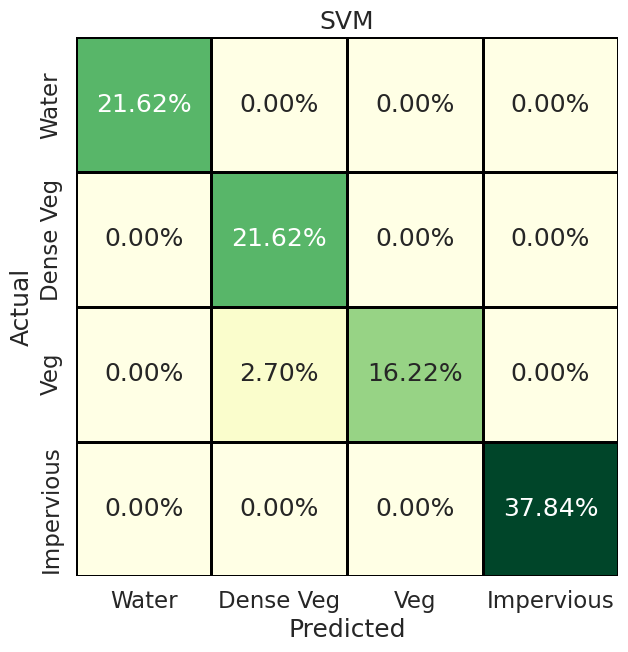

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = cm/np.sum(cm)

plt.figure(figsize=(7, 7), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)

sns.heatmap(cm_percent,
            xticklabels=lulc_name,
            yticklabels=lulc_name,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

plt.title(cName)
plt.xlabel('Predicted')
plt.ylabel('Actual')
#plt.savefig(f'../figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

In [ ]:
%%time
cName = 'SVM'
exp_name = f'materials/results/lulc_{cName}.tif'


img = rio.open(raster_loc)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')


pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)

out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1,
                                          dtype='uint8',
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

print(f'Map saved {cName}.................')

Height: 406
Width: 763
Bands: 4

reshaped full data shape  for prediction:  (309778, 4)
Prediction Done, now exporting raster 

Map saved SVM.................
CPU times: user 821 ms, sys: 6.82 ms, total: 828 ms
Wall time: 828 ms
